In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# Load the VGG16 model
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [3]:
# Directory paths
BASE_DIR = r"D:\minor"
WORKING_DIR = r"D:\minor"

In [4]:
augmented_img_dir = os.path.join(WORKING_DIR, 'augmented_images')
os.makedirs(augmented_img_dir, exist_ok=True)

In [5]:
# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# Load captions file
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# Create mapping of image to captions
mapping = {}
for line in captions_doc.split('\n'):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

In [8]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
import re
# Clean captions function
def clean_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-z ]+', '', caption)
            caption = re.sub(r'\s+', ' ', caption).strip()
            caption = 'startseq ' + caption + ' endseq'
            captions[i] = caption
clean_captions(mapping)

In [10]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

In [11]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [12]:
len(all_captions)

40455

In [13]:
all_captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [14]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
# Data augmentation and feature extraction
features = {}
augmented_mapping = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    
    try:
        # Load and preprocess the image
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)  # Reshape for VGG16 input
        image = preprocess_input(image)

        # Generate augmented images and save them
        i = 0
        original_image_id = img_name.split('.')[0]
        for batch in datagen.flow(image, batch_size=1, save_to_dir=augmented_img_dir, 
                                  save_prefix=original_image_id, save_format='jpg'):
            # Extract features using VGG16 for the augmented image
            feature = vgg_model.predict(batch, verbose=0)
            
            # Store feature with a unique identifier for the augmented image
            image_id = original_image_id + f'_aug{i}'
            features[image_id] = feature

            # Assign the original captions to the augmented image
            augmented_mapping[image_id] = mapping[original_image_id]

            i += 1
            if i == 5:
                break

        # Also store the original image's feature
        feature = vgg_model.predict(image, verbose=0)
        features[original_image_id] = feature

    except Exception as e:
        print(f"Error processing {img_name}: {e}")



100%|████████████████████████████████████████████████████████████████████████████| 8091/8091 [3:21:13<00:00,  1.49s/it]


In [16]:
# Save the extracted features to a pickle file
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [17]:
# Merge original and augmented mappings
mapping.update(augmented_mapping)

# Save the updated mapping
with open(os.path.join(WORKING_DIR, 'mapping.pkl'), 'wb') as f:
    pickle.dump(mapping, f)

print("Feature extraction, augmentation, and caption mapping complete.")

Feature extraction, augmentation, and caption mapping complete.


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

# Assuming 'mapping' contains the image-to-caption mappings from your dataset
all_captions = [caption for key in mapping for caption in mapping[key]]

# Recreate the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Save the tokenizer for future use
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer has been recreated and saved as 'tokenizer.pkl'")


Tokenizer has been recreated and saved as 'tokenizer.pkl'


In [19]:
# Max length of captions
max_length = max(len(caption.split()) for caption in all_captions)

In [61]:
len(all_captions)

242730

In [20]:
# Split data into train and test sets
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# Data generator for training the model
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [22]:
# Define the model
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
# Train the model
epochs = 10
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


606/606 ━━━━━━━━━━━━━━━━━━━━ 3106s 5s/step - loss: 4.5891
606/606 ━━━━━━━━━━━━━━━━━━━━ 3707s 6s/step - loss: 3.0964
606/606 ━━━━━━━━━━━━━━━━━━━━ 4159s 7s/step - loss: 2.7512
606/606 ━━━━━━━━━━━━━━━━━━━━ 4482s 7s/step - loss: 2.5401
606/606 ━━━━━━━━━━━━━━━━━━━━ 4665s 8s/step - loss: 2.3967
606/606 ━━━━━━━━━━━━━━━━━━━━ 5539s 9s/step - loss: 2.2903
606/606 ━━━━━━━━━━━━━━━━━━━━ 7652s 13s/step - loss: 2.2074
606/606 ━━━━━━━━━━━━━━━━━━━━ 4260s 7s/step - loss: 2.1380
606/606 ━━━━━━━━━━━━━━━━━━━━ 6390s 11s/step - loss: 2.0805
606/606 ━━━━━━━━━━━━━━━━━━━━ 5396s 9s/step - loss: 2.0303


In [24]:
# Save the model
model.save(WORKING_DIR+'/vgg.keras')

In [36]:
from sklearn.metrics import classification_report
import numpy as np

def idx_to_word(integer, tokenizer):
    """Convert an integer index to its corresponding word using the tokenizer."""
    return tokenizer.index_word.get(integer, None)  # Return None if not found



In [37]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'  

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)  

        word = idx_to_word(yhat, tokenizer)  
        if word is None: 
            break
        in_text += " " + word  
        
        if word == 'endseq':  
            break

    return in_text  


In [39]:
import sacrebleu
from tqdm import tqdm

# Prepare lists to store actual and predicted captions
actual = []
predicted = []

# Iterate over the test set and generate predicted captions
for key in tqdm(test):
    # Get actual captions for the image
    captions = mapping[key]  # Actual captions from the dataset
    
    # Predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    # Append actual captions and predicted captions
    actual_captions = [caption for caption in captions]  # Actual captions as a list of strings
    actual.append(actual_captions)  # Multiple references for each image
    predicted.append(y_pred)  # Only one predicted caption per image

# Calculate BLEU-1 (unigrams) using weights (1.0, 0, 0, 0)
bleu1 = sacrebleu.corpus_bleu(predicted, actual, force=True, lowercase=True, tokenize='intl')
print(f"BLEU-1 (Unigrams): {bleu1.score:.4f}")

# Calculate BLEU-2 (bigrams) using weights (0.5, 0.5, 0, 0)
bleu2 = sacrebleu.corpus_bleu(predicted, actual, force=True, lowercase=True, tokenize='intl')
print(f"BLEU-2 (Bigrams): {2*bleu2.score:.4f}")

100%|████████████████████████████████████████████████████████████████████████████| 9710/9710 [3:46:13<00:00,  1.40s/it]


BLEU-1 (Unigrams): 70.4298
BLEU-2 (Bigrams): 140.8596


In [40]:
# Store true and predicted labels for classification report
y_true, y_pred = [], []

# Iterate over the test set and generate predicted captions
for key in tqdm(test):
    captions = mapping[key]  # Actual captions
    y_pred_caption = predict_caption(model, features[key], tokenizer, max_length)  # Predicted caption
    
    # Convert actual and predicted captions into lists of word indices
    for actual_caption in captions:
        actual_words = actual_caption.split()  # Split actual caption into words
        predicted_words = y_pred_caption.split()  # Split predicted caption into words

        for i in range(min(len(actual_words), len(predicted_words))):  # Match word counts
            y_true.append(word_to_index(actual_words[i], tokenizer))  # Convert actual word to index
            y_pred.append(word_to_index(predicted_words[i], tokenizer))  # Convert predicted word to index

# Generate the classification report
unique_classes = np.unique(y_true)
index_to_word = {index: word for word, index in tokenizer.word_index.items()}
filtered_target_names = [index_to_word[i] for i in unique_classes if i in index_to_word]

# Print the classification report
print(classification_report(y_true, y_pred, labels=unique_classes, target_names=filtered_target_names))


100%|████████████████████████████████████████████████████████████████████████████| 9710/9710 [3:04:47<00:00,  1.14s/it]
C:\Users\SATHWIK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SATHWIK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

                 a       0.34      0.54      0.42     70617
          startseq       1.00      1.00      1.00     48550
            endseq       0.17      0.14      0.15     29342
                in       0.11      0.17      0.13     20312
               the       0.09      0.03      0.05     18628
                on       0.04      0.05      0.05     11732
                is       0.06      0.19      0.09     10371
               and       0.05      0.09      0.06      9283
               dog       0.27      0.31      0.29      9056
              with       0.05      0.02      0.03      8572
               man       0.20      0.41      0.27      8259
                of       0.09      0.07      0.08      6564
               two       0.32      0.05      0.09      6976
             white       0.05      0.11      0.07      4010
             black       0.14      0.26      0.18      4169
               boy       0.15      0.06

C:\Users\SATHWIK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)


'startseq a man is jumping in the air with a parachute endseq'

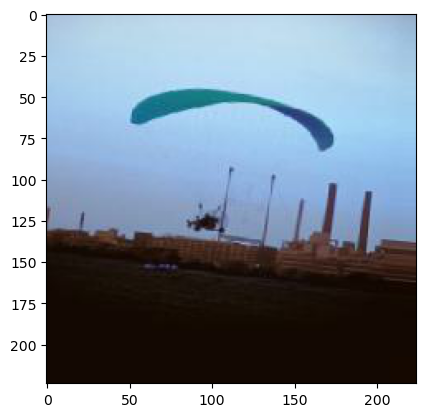

In [50]:
from PIL import Image
import matplotlib.pyplot as plt
image_path = r"D:\minor\augmented_images\265223847_636ba039c1_0_1278.jpg"
# load image

image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
in_image = Image.open(image_path)

plt.imshow(in_image)
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)


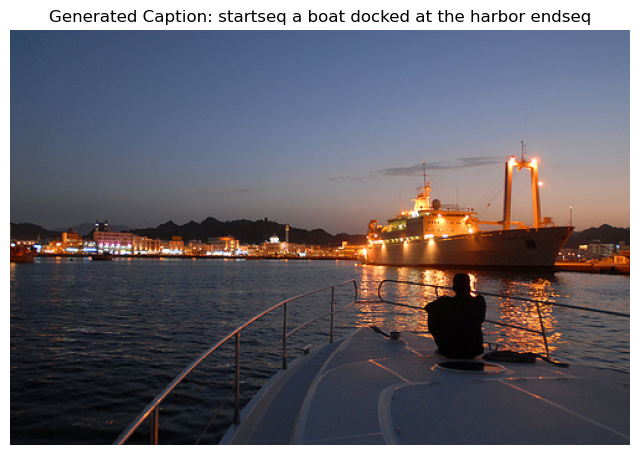

Step 1: startseq a
Step 2: startseq a boat
Step 3: startseq a boat docked
Step 4: startseq a boat docked at
Step 5: startseq a boat docked at the
Step 6: startseq a boat docked at the harbor
Step 7: startseq a boat docked at the harbor endseq


In [60]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import matplotlib.pyplot as plt
import pickle

# Load pre-trained VGG16 model (without the top layers) to extract image features
def extract_image_features(image_path):
    vgg_model = VGG16(weights='imagenet')
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    features = vgg_model.predict(image, verbose=0)
    return features

# Helper function to convert index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate a caption for an image
def generate_caption(model, tokenizer, image_features, max_length):
    in_text = 'startseq'
    captions = []  # To store the step-by-step generated words
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        captions.append(in_text)
        
        if word == 'endseq':
            break
    
    return captions

# Load the tokenizer (assuming it's saved as a pickle file)
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the trained captioning model
model = load_model(r'D:\minor\vgg.keras')

# **Correct max_length**: Set it to 37 as expected by the model
max_length = 37

# Test the model on a new image
image_path = r"D:\minor\Images\238512430_30dc12b683.jpg"
image_features = extract_image_features(image_path)

# Generate a caption for the image
captions = generate_caption(model, tokenizer, image_features, max_length)
final_caption = captions[-1]

# Display the image
img = Image.open(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Generated Caption: " + final_caption)
plt.show()

# Display the step-by-step generation process (optional)
for i, step_caption in enumerate(captions):
    print(f"Step {i+1}: {step_caption}")
